# __Flight Sentiment Analysis__

In [1]:
import pandas as pd
import numpy as np
import re
import contractions
import nltk
import contractions
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
import text_preprocessing as tp
import utils
import ml_models as md
import spacy
import seaborn as sb
import demoji
import contractions

from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from flashtext import KeywordProcessor
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aurad\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Importing Dataset for Flight Data

Use the Kaggle dataset containing information about tweets related to flights will be utilized in the process of traning the model.

__a. Data Source:__ https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [2]:
# Open file containing flight data
flight_review_df = pd.read_csv("./Dataset/Reviews/airline_review_tweets.csv")
flight_review_df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306100000,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin test,NaN,0,test only for deletion @VirginAmerica What @dh...,NaN,2015-02-24 11:35,NaN,Eastern Time (US & Canada)
1,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35,NaN,Eastern Time (US & Canada)
2,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15,NaN,Pacific Time (US & Canada)
3,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15,Lets Play,Central Time (US & Canada)
4,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15,NaN,Pacific Time (US & Canada)


In [3]:
# List all the columns in flight data's dataframe
flight_review_df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

## Exploratory Data Analysis

Drop columns that are not relevant

In [4]:
# Drop columns that are not relevant
del_columns = ['tweet_id', 'negativereason', 'negativereason_confidence', 'airline_sentiment_gold','name','negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_location','user_timezone']
flight_review_df = flight_review_df.drop(del_columns, axis=1)

flight_review_df.head(5)

,airline_sentiment,airline_sentiment_confidence,airline,text,tweet_created
0,neutral,1.0000,Virgin America,test only for deletion @VirginAmerica What @dh...,2015-02-24 11:35
1,neutral,1.0000,Virgin America,@VirginAmerica What @dhepburn said.,2015-02-24 11:35
2,positive,0.3486,Virgin America,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15
3,neutral,0.6837,Virgin America,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15
4,negative,1.0000,Virgin America,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15


Drop duplicate records in flight data

In [5]:
print(f"Record count before removing duplicates => {flight_review_df.shape[0]}")
flight_review_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {flight_review_df.shape[0]}")

Record count before removing duplicates => 14641
Record count after removing duplicates  => 14561


Check and resolve missing values for `flight data`

In [6]:
# Check for missing values in flight data
print(flight_review_df.isna().sum())

try:
    # Check for missing values in flight data
    missing_values = flight_review_df.isna().sum()
    
    # Check if there are any missing values
    if missing_values.sum() > 0:
        # Display records with missing values
        print("Records with missing values:")
        missing_records = flight_review_df[flight_review_df.isna().any(axis=1)]
        print(missing_records)
    else:
        print("No missing values found in the flight data.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


airline_sentiment               0
airline_sentiment_confidence    0
airline                         0
text                            0
tweet_created                   0
dtype: int64
No missing values found in the flight data.


#### __Data Wrangling__:

Conduct data wrangling on `flight metadata` to transform and structure data into a desired format

In [7]:
# Rename the 'text' column to 'review'
flight_review_df.rename(columns={'text': 'review'}, inplace=True)

# Show DataFrame to check if 'review' column instead of 'text'
flight_review_df.head(5)

,airline_sentiment,airline_sentiment_confidence,airline,review,tweet_created
0,neutral,1.0000,Virgin America,test only for deletion @VirginAmerica What @dh...,2015-02-24 11:35
1,neutral,1.0000,Virgin America,@VirginAmerica What @dhepburn said.,2015-02-24 11:35
2,positive,0.3486,Virgin America,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15
3,neutral,0.6837,Virgin America,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15
4,negative,1.0000,Virgin America,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15


In [8]:
# Convert 'tweet_created' to datetime
flight_review_df['tweet_created'] = pd.to_datetime(flight_review_df['tweet_created'])

# Extract year, month into separate columns
flight_review_df['review_year'] = flight_review_df['tweet_created'].dt.year
flight_review_df['review_month'] = flight_review_df['tweet_created'].dt.month

flight_review_df.head(5)

,airline_sentiment,airline_sentiment_confidence,airline,review,tweet_created,review_year,review_month
0,neutral,1.0000,Virgin America,test only for deletion @VirginAmerica What @dh...,2015-02-24 11:35:00,2015,2
1,neutral,1.0000,Virgin America,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:00,2015,2
2,positive,0.3486,Virgin America,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:00,2015,2
3,neutral,0.6837,Virgin America,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:00,2015,2
4,negative,1.0000,Virgin America,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:00,2015,2


In [9]:
# Show statistical summary of flight review
flight_review_df.describe()

,airline_sentiment_confidence,review_year,review_month
count,14561.000000,14561.0,14561.0
mean,0.899627,2015.0,2.0
std,0.163105,0.0,0.0
min,0.335000,2015.0,2.0
25%,0.691900,2015.0,2.0
50%,1.000000,2015.0,2.0
75%,1.000000,2015.0,2.0
max,1.000000,2015.0,2.0


In [10]:
# Drop year and month as the dataset only contains records for February 2015
flight_review_df = flight_review_df.drop(columns=['review_year', 'review_month', 'tweet_created'], axis=1)
flight_review_df.head(10)

,airline_sentiment,airline_sentiment_confidence,airline,review
0,neutral,1.0000,Virgin America,test only for deletion @VirginAmerica What @dh...
1,neutral,1.0000,Virgin America,@VirginAmerica What @dhepburn said.
2,positive,0.3486,Virgin America,@VirginAmerica plus you've added commercials t...
3,neutral,0.6837,Virgin America,@VirginAmerica I didn't today... Must mean I n...
4,negative,1.0000,Virgin America,@VirginAmerica it's really aggressive to blast...
5,negative,1.0000,Virgin America,@VirginAmerica and it's a really big bad thing...
6,negative,1.0000,Virgin America,@VirginAmerica seriously would pay $30 a fligh...
7,positive,0.6745,Virgin America,"@VirginAmerica yes, nearly every time I fly VX..."
8,neutral,0.6340,Virgin America,@VirginAmerica Really missed a prime opportuni...
9,positive,0.6559,Virgin America,"@virginamerica Well, I didn't…but NOW I DO! :-D"


#### __For Text Pre-processing__:

__The flight review undergo the following steps during the initial data pre-processing stage__
- Remove non-grammatical text like emails and URLs
- Remove "at the rate" and #
- Replace emojis with English word/s
- Handle contractions
- Handle slang words

In [11]:
# Download the emoji library data
demoji.download_codes()

# Extract emojis from all reviews
all_emojis = flight_review_df['review'].apply(lambda x : list(demoji.findall(x).keys())).sum()

# Count the frequency of each emoji
emoji_counts = Counter(all_emojis)

# Get the top 10 emojis by frequency
top_10_emojis = emoji_counts.most_common(10)

# Display the top 10 emojis and their frequencies
for emoji, count in top_10_emojis:
    print(f"Emoji: {emoji}, Count: {count}")

Emoji: ✈️, Count: 39
Emoji: 👍, Count: 31
Emoji: 😊, Count: 28
Emoji: 😂, Count: 28
Emoji: 😭, Count: 25
Emoji: 😡, Count: 22
Emoji: ❤️, Count: 21
Emoji: 🙏, Count: 21
Emoji: 😢, Count: 17
Emoji: 😒, Count: 17


In [12]:
slang_word_dict = tp.get_slang_words(webscraped=True)
emoji_dict = tp.get_emojis()

def initial_text_preprocessing(text):
    try:
        # Remove non-grammatical text
        text = tp.remove_email_address(text)
        text = tp.remove_hyperlink(text)
        text = tp.replace_html_char(text)
        text = tp.remove_attherate(text)
        text = tp.remove_hashtag(text)    

        # Replace emojis in the 'review' column
        text = tp.replace_emojis_unicode(text)
        text = emoji_dict.replace_keywords(text)

        # Handle contractions
        text = contractions.fix(text)

        # Replace slang words
        text = slang_word_dict.replace_keywords(text)

    except Exception as err:
        print(f"ERROR: {err}")
        print(f"Input Text: {text}")

    return text


#flight_review_df['cleaned_review'] = flight_review_df['review'].applymap(initial_text_preprocessing)
flight_review_df['cleaned_review'] = flight_review_df['review'].apply(initial_text_preprocessing)

# Display the comparison between the top 5 original review summaries and their cleaned versions
for i in range(5):
    print("Original Review:")
    print(flight_review_df['review'][i])
    print("\nCleaned Review Summary:")
    print(flight_review_df['cleaned_review'][i])
    print("="*100)

ERROR: [Errno 2] No such file or directory: './dictionary/slang_words_dictionary.pkl'
Original Review:
test only for deletion @VirginAmerica What @dhepburn said. #hastag before  ❤️ emoji before brb ikr lmao

Cleaned Review Summary:
test only for deletion VirginAmerica What dhepburn said.  before   red heart  emoji before brb ikr lmao
Original Review:
@VirginAmerica What @dhepburn said.

Cleaned Review Summary:
VirginAmerica What dhepburn said.
Original Review:
@VirginAmerica plus you've added commercials to the experience... tacky.

Cleaned Review Summary:
VirginAmerica plus you have added commercials to the experience... tacky.
Original Review:
@VirginAmerica I didn't today... Must mean I need to take another trip!

Cleaned Review Summary:
VirginAmerica I did not today... Must mean I need to take another trip!
Original Review:
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse

Cleaned Review Summary:
VirginAm

__Utilize regular expressions to eliminate punctuation, substitute whitespaces, and filter out stopwords from flight reviews__

In [13]:
# Initialize the English stop words list
list_of_stopwords = set(stopwords.words('english')) - set(['not'])

def supplemental_text_preprocessing(text):

    # Remove leading and trailing whitespaces
    text = text.strip()

    # Replace multiple whitespaces with a single space
    text = tp.replace_whitespace(text)

    # Remove stopwords
    # text = tp.remove_stopwords(text, list_of_stopwords)

    return text

# Apply text cleaning to 'cleaned_review' column
flight_review_df['cleaned_review'] = flight_review_df['cleaned_review'].apply(supplemental_text_preprocessing)

# Display the comparison between the top 5 original review and their cleaned versions
for i in range(5):
    print("Original Review:")
    print(flight_review_df['review'][i])
    print("\nCleaned Review (Extra Whitespaces Removed, Stopwords Removed):")
    print(flight_review_df['cleaned_review'][i])
    print("="*100)

Original Review:
test only for deletion @VirginAmerica What @dhepburn said. #hastag before  ❤️ emoji before brb ikr lmao

Cleaned Review (Extra Whitespaces Removed, Stopwords Removed):
test only for deletion VirginAmerica What dhepburn said. before red heart emoji before brb ikr lmao
Original Review:
@VirginAmerica What @dhepburn said.

Cleaned Review (Extra Whitespaces Removed, Stopwords Removed):
VirginAmerica What dhepburn said.
Original Review:
@VirginAmerica plus you've added commercials to the experience... tacky.

Cleaned Review (Extra Whitespaces Removed, Stopwords Removed):
VirginAmerica plus you have added commercials to the experience... tacky.
Original Review:
@VirginAmerica I didn't today... Must mean I need to take another trip!

Cleaned Review (Extra Whitespaces Removed, Stopwords Removed):
VirginAmerica I did not today... Must mean I need to take another trip!
Original Review:
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces

Show data frequency for each sentiment

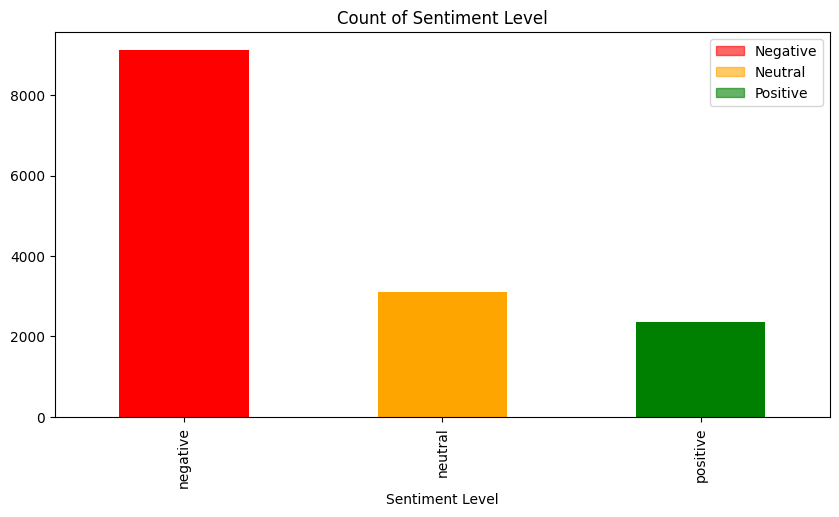

In [14]:
# Define the colors for each sentiment
sentiment_colors = {
    'negative': 'red',
    'neutral': 'orange',
    'positive': 'green'
}

# Count the reviews based on dataset Sentiment Level
sentiment_counts = flight_review_df['airline_sentiment'].value_counts().sort_index()
sentiments = sentiment_counts.index
colors = [sentiment_colors[s] for s in sentiments]

# Create the bar chart
ax = sentiment_counts.plot(kind='bar', title='Count of Sentiment Level', figsize=(10, 5), color=colors)

ax.set_xlabel('Sentiment Level')

# Add a custom legend for sentiments
legend_labels = {
    'negative': 'Negative',
    'neutral': 'Neutral',
    'positive': 'Positive'
}

legend_handles = [plt.Rectangle((0, 0), 1, 1, color=sentiment_colors[s], alpha=0.6, label=label)
                  for s, label in legend_labels.items()]

ax.legend(handles=legend_handles, loc='upper right')

plt.show()


In [15]:
# Rearrange the order of columns
desired_order = ['airline', 'review', 'cleaned_review', 'airline_sentiment_confidence', 'airline_sentiment']
flight_review_df = flight_review_df[desired_order]
flight_review_df.head(5)

,airline,review,cleaned_review,airline_sentiment_confidence,airline_sentiment
0,Virgin America,test only for deletion @VirginAmerica What @dh...,test only for deletion VirginAmerica What dhep...,1.0000,neutral
1,Virgin America,@VirginAmerica What @dhepburn said.,VirginAmerica What dhepburn said.,1.0000,neutral
2,Virgin America,@VirginAmerica plus you've added commercials t...,VirginAmerica plus you have added commercials ...,0.3486,positive
3,Virgin America,@VirginAmerica I didn't today... Must mean I n...,VirginAmerica I did not today... Must mean I n...,0.6837,neutral
4,Virgin America,@VirginAmerica it's really aggressive to blast...,VirginAmerica it is really aggressive to blast...,1.0000,negative


## Pre-trained Model Predictions and Evaluation

Execute the two pre-trained models for sentiment analysis, namely VADER and RoBERTa, then get their predictions

__1. VADER (Valence Aware Dictionary for Sentiment Reasoning)__

VADER is a pre-trained sentiment analysis model designed for analyzing the sentiment of text, particularly in the context of social media. Developed by researchers at the Georgia Institute of Technology, VADER is specifically tuned to handle the nuances of sentiment expressed in short and informal texts, such as tweets or online comments.

In [16]:
def process_vader_sentiment(df):
    # Generate sentiments using VADER
    df['vader_sentiment'] = df['cleaned_review'].apply(lambda x : md.generate_vader_labels(x))

    # Flag to check if vader sentiments match with the airline sentiments
    df['vader_is_matched'] = df['vader_sentiment'] == df['airline_sentiment']

    return df


try:  
    print("Parallel processing of flight airline reviews...")
    flight_review_df = utils.parallel_processing(flight_review_df, process_vader_sentiment)

    display(flight_review_df.head(10))
except Exception as err:
    print(f"ERROR: {err}")

Parallel processing of flight airline reviews...


,airline,review,cleaned_review,airline_sentiment_confidence,airline_sentiment,vader_sentiment,vader_is_matched
0,Virgin America,test only for deletion @VirginAmerica What @dh...,test only for deletion VirginAmerica What dhep...,1.0000,neutral,positive,False
1,Virgin America,@VirginAmerica What @dhepburn said.,VirginAmerica What dhepburn said.,1.0000,neutral,neutral,True
2,Virgin America,@VirginAmerica plus you've added commercials t...,VirginAmerica plus you have added commercials ...,0.3486,positive,neutral,False
3,Virgin America,@VirginAmerica I didn't today... Must mean I n...,VirginAmerica I did not today... Must mean I n...,0.6837,neutral,neutral,True
4,Virgin America,@VirginAmerica it's really aggressive to blast...,VirginAmerica it is really aggressive to blast...,1.0000,negative,negative,True
5,Virgin America,@VirginAmerica and it's a really big bad thing...,VirginAmerica and it is a really big bad thing...,1.0000,negative,negative,True
6,Virgin America,@VirginAmerica seriously would pay $30 a fligh...,VirginAmerica seriously would pay $30 a flight...,1.0000,negative,negative,True
7,Virgin America,"@VirginAmerica yes, nearly every time I fly VX...","VirginAmerica yes, nearly every time I fly VX ...",0.6745,positive,neutral,False
8,Virgin America,@VirginAmerica Really missed a prime opportuni...,VirginAmerica Really missed a prime opportunit...,0.6340,neutral,positive,False
9,Virgin America,"@virginamerica Well, I didn't…but NOW I DO! :-D","virginamerica Well, I did not…but NOW I DO! la...",0.6559,positive,positive,True


__2. RoBERTa (Robustly Optimized BERT Pre-training)__

RoBERTa is a natural language processing (NLP) model developed by Facebook AI. It is an extension and optimization of the BERT (Bidirectional Encoder Representations from Transformers) model architecture. RoBERTa was introduced to address some limitations and enhance the performance of BERT.

In [17]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

def process_roberta_sentiment(df):
    # Generate sentiments using RoBERTa
    df['roberta_sentiment'] = df['cleaned_review'].apply(lambda x : md.generate_roberta_labels(x, model, tokenizer))

    # Flag to check if vader sentiments match with the airline sentiments
    df['roberta_is_matched'] = df['roberta_sentiment'] == df['airline_sentiment']

    return df


try:  
    print("Parallel processing of flight airline reviews...")
    flight_review_df = utils.parallel_processing(flight_review_df, process_roberta_sentiment)

    display(flight_review_df.head(10))
except Exception as err:
    print(f"ERROR: {err}")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Parallel processing of flight airline reviews...


,airline,review,cleaned_review,airline_sentiment_confidence,airline_sentiment,vader_sentiment,vader_is_matched,roberta_sentiment,roberta_is_matched
0,Virgin America,test only for deletion @VirginAmerica What @dh...,test only for deletion VirginAmerica What dhep...,1.0000,neutral,positive,False,neutral,True
1,Virgin America,@VirginAmerica What @dhepburn said.,VirginAmerica What dhepburn said.,1.0000,neutral,neutral,True,neutral,True
2,Virgin America,@VirginAmerica plus you've added commercials t...,VirginAmerica plus you have added commercials ...,0.3486,positive,neutral,False,negative,False
3,Virgin America,@VirginAmerica I didn't today... Must mean I n...,VirginAmerica I did not today... Must mean I n...,0.6837,neutral,neutral,True,neutral,True
4,Virgin America,@VirginAmerica it's really aggressive to blast...,VirginAmerica it is really aggressive to blast...,1.0000,negative,negative,True,negative,True
5,Virgin America,@VirginAmerica and it's a really big bad thing...,VirginAmerica and it is a really big bad thing...,1.0000,negative,negative,True,negative,True
6,Virgin America,@VirginAmerica seriously would pay $30 a fligh...,VirginAmerica seriously would pay $30 a flight...,1.0000,negative,negative,True,negative,True
7,Virgin America,"@VirginAmerica yes, nearly every time I fly VX...","VirginAmerica yes, nearly every time I fly VX ...",0.6745,positive,neutral,False,neutral,False
8,Virgin America,@VirginAmerica Really missed a prime opportuni...,VirginAmerica Really missed a prime opportunit...,0.6340,neutral,positive,False,negative,False
9,Virgin America,"@virginamerica Well, I didn't…but NOW I DO! :-D","virginamerica Well, I did not…but NOW I DO! la...",0.6559,positive,positive,True,neutral,False


#### __Feature Engineering:__

Convert airline, RoBERTa and VADER sentiment labels to numerical representation [Negative:0, Neutral:1, Positive:2]

In [18]:
encoder = LabelEncoder()
flight_review_df['airline_sentiment_encoded'] = encoder.fit_transform(flight_review_df['airline_sentiment'])
flight_review_df['vader_sentiment_encoded'] = encoder.fit_transform(flight_review_df['vader_sentiment'])
flight_review_df['roberta_sentiment_encoded'] = encoder.fit_transform(flight_review_df['roberta_sentiment'])
flight_review_df.head(5)

,airline,review,cleaned_review,airline_sentiment_confidence,airline_sentiment,vader_sentiment,vader_is_matched,roberta_sentiment,roberta_is_matched,airline_sentiment_encoded,vader_sentiment_encoded,roberta_sentiment_encoded
0,Virgin America,test only for deletion @VirginAmerica What @dh...,test only for deletion VirginAmerica What dhep...,1.0000,neutral,positive,False,neutral,True,1,2,1
1,Virgin America,@VirginAmerica What @dhepburn said.,VirginAmerica What dhepburn said.,1.0000,neutral,neutral,True,neutral,True,1,1,1
2,Virgin America,@VirginAmerica plus you've added commercials t...,VirginAmerica plus you have added commercials ...,0.3486,positive,neutral,False,negative,False,2,1,0
3,Virgin America,@VirginAmerica I didn't today... Must mean I n...,VirginAmerica I did not today... Must mean I n...,0.6837,neutral,neutral,True,neutral,True,1,1,1
4,Virgin America,@VirginAmerica it's really aggressive to blast...,VirginAmerica it is really aggressive to blast...,1.0000,negative,negative,True,negative,True,0,0,0


In [19]:
flight_review_df.to_csv("result.csv")

#### __Model Evaluation:__

In [20]:
airline_sentiments = flight_review_df['airline_sentiment_encoded']
roberta_predictions = flight_review_df['vader_sentiment_encoded']
vader_predictions = flight_review_df['roberta_sentiment_encoded']

__For VADER:__

Classification Report for VADER Predictions

              precision    recall  f1-score   support

           0       0.94      0.69      0.80      9116
           1       0.46      0.70      0.56      3092
           2       0.66      0.89      0.76      2353

    accuracy                           0.73     14561
   macro avg       0.69      0.76      0.70     14561
weighted avg       0.79      0.73      0.74     14561



Text(50.722222222222214, 0.5, 'Predicted Class')

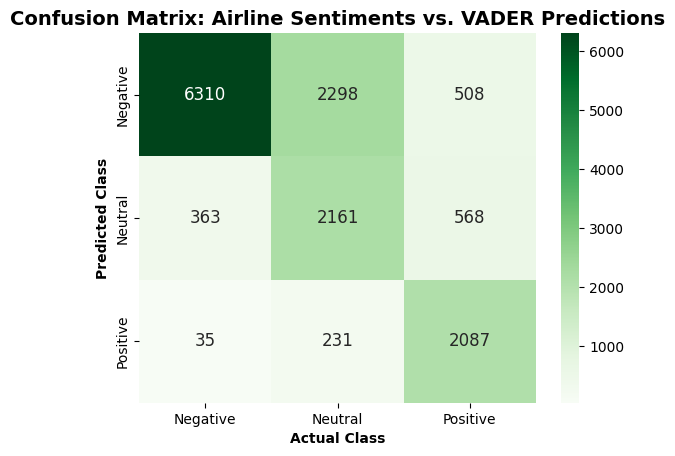

In [21]:
print("Classification Report for VADER Predictions\n")
print(classification_report(airline_sentiments, vader_predictions))

# Create a confusion matrix
class_labels = ['Negative', 'Neutral', 'Positive']
cm = confusion_matrix(airline_sentiments, vader_predictions)
cm_matrix = pd.DataFrame(data=cm, columns=class_labels, index=class_labels)

sb.heatmap(cm_matrix, cmap='Greens', annot=True, fmt='d', annot_kws={"size": 12})

plt.title('Confusion Matrix: Airline Sentiments vs. VADER Predictions', fontsize=14, fontweight='bold')
plt.xlabel('Actual Class', fontweight='bold')
plt.ylabel('Predicted Class', fontweight='bold')

__For RoBERTa:__

Classification Report for RoBERTa Predictions

              precision    recall  f1-score   support

           0       0.90      0.40      0.56      9116
           1       0.36      0.36      0.36      3092
           2       0.29      0.90      0.43      2353

    accuracy                           0.47     14561
   macro avg       0.51      0.55      0.45     14561
weighted avg       0.69      0.47      0.50     14561



Text(50.722222222222214, 0.5, 'Predicted Class')

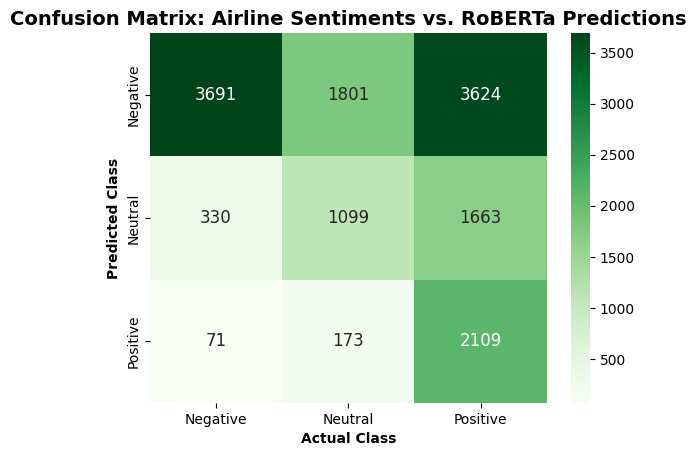

In [22]:
print("Classification Report for RoBERTa Predictions\n")
print(classification_report(airline_sentiments, roberta_predictions))

# Create a confusion matrix
class_labels = ['Negative', 'Neutral', 'Positive']
cm = confusion_matrix(airline_sentiments, roberta_predictions)
cm_matrix = pd.DataFrame(data=cm, columns=class_labels, index=class_labels)

sb.heatmap(cm_matrix, cmap='Greens', annot=True, fmt='d', annot_kws={"size": 12})

plt.title('Confusion Matrix: Airline Sentiments vs. RoBERTa Predictions', fontsize=14, fontweight='bold')
plt.xlabel('Actual Class', fontweight='bold')
plt.ylabel('Predicted Class', fontweight='bold')

## Group Members
- Auradee Castro
- Bhumika Rajendra Babu
- Miraj Sinya
- Olivia Deguit
- Roger Mais